In [ ]:
# !pip install livelossplot -q
# !pip install tensorflowjs -q
!nvidia-smi
# FER - 2013 #kaggle competition
!wget https://s3.ayushgoyal.dev/public/test.zip  -P /content
!wget https://s3.ayushgoyal.dev/public/train.zip -P /content
!pip install wandb -q

#Unzip test file 
import zipfile
with zipfile.ZipFile('/content/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

#Unzip train file 
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 112kB 12.0MB/s 
Sun Nov  8 07:17:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+--

In [ ]:
import wandb
from wandb.keras import WandbCallback
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# from wandb import magic
run = wandb.init(project="ms-project")

epoch,34
loss,1.00735
accuracy,0.62093
val_loss,1.00762
val_accuracy,0.62333
lr,1e-05
_step,34
_runtime,904
_timestamp,1604822008
best_val_loss,1.0055
best_epoch,29


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▅▆▆▆▇▇▇▇▇███████████████████████
val_loss,█▆▄▄▃▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▄▆▆▆▆▆▇█████████████████████████
lr,█████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) # spatial tilting

train_generator = datagen_train.flow_from_directory("/content/dataset/train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# datagen_validation = ImageDataGenerator(horizontal_flip=True)
datagen_validation = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/dataset/test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# num_classes = 7
# model = Sequential()

# #1st convolution layer
# model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
# model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

# #2nd convolution layer
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

# #3rd convolution layer
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

# model.add(Flatten())

# #fully connected neural networks
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(num_classes, activation='softmax'))

# # model.load_weights("facial_expression_model_weights.h5")



# Initialising the CNN
num_classes = 7
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 128)      

In [ ]:
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
labels_wandb = []
for i in train_generator.class_indices.keys():
  labels_wandb.append(i)
print(labels_wandb)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# %%wandb
# for this first model


# epochs = 20
# steps_per_epoch = train_generator.n//train_generator.batch_size
# validation_steps = validation_generator.n//validation_generator.batch_size

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=2, min_lr=0.00001, mode='auto')
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
# callbacks = [checkpoint, WandbCallback(data_type="image",labels=labels_wandb)] #PlotLossesKerasTF(), reduce_lr 
# # labels are in incorrect order

# history = model.fit(
#     x=train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     validation_data = validation_generator,
#     validation_steps = validation_steps,
#     callbacks=callbacks
# )

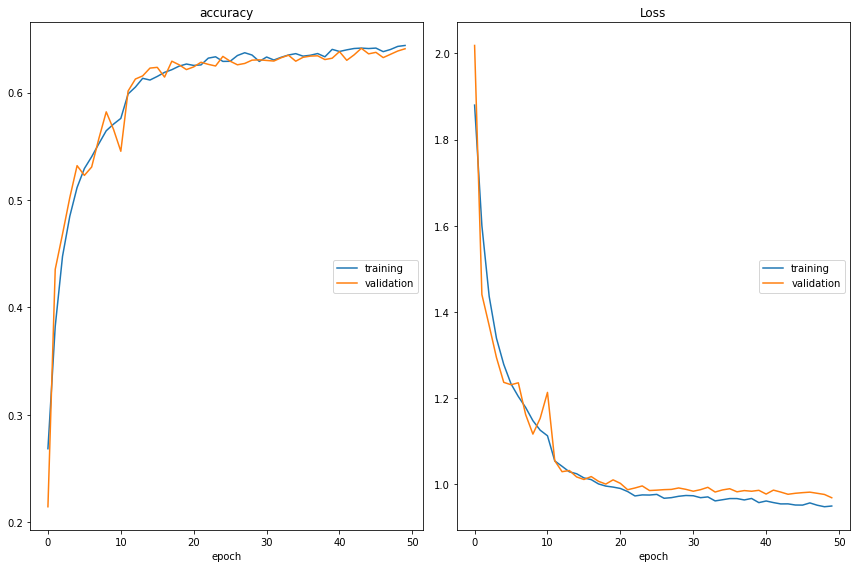

accuracy
	training         	 (min:    0.268, max:    0.644, cur:    0.644)
	validation       	 (min:    0.214, max:    0.641, cur:    0.641)
Loss
	training         	 (min:    0.948, max:    1.880, cur:    0.950)
	validation       	 (min:    0.969, max:    2.018, cur:    0.969)

Epoch 00050: saving model to model_weights.h5
448/448 [==============================] - 27s 60ms/step - loss: 0.9497 - accuracy: 0.6438 - val_loss: 0.9689 - val_accuracy: 0.6408


In [ ]:
# %%time
%%wandb

epochs = 50

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr,  WandbCallback(data_type="image",labels=labels_wandb)]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [ ]:
run.finish()
# magic
# num_classes


epoch,2
loss,1.04414
accuracy,0.60627
val_loss,1.04082
val_accuracy,0.60533
lr,5e-05
_step,2
_runtime,93
_timestamp,1604821048
best_val_loss,1.03605
best_epoch,0


epoch,▁▅█
loss,█▂▁
accuracy,▁▆█
val_loss,▁█▆
val_accuracy,▆█▁
lr,▁▁▁
_step,▁▅█
_runtime,▁▅█
_timestamp,▁▅█


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)